# Overview
.. index::
   pair: Overview; Dense Vectors

.. index::
   pair: Overview; Geometries

.. index::
   pair: Overview; Geometries

To facilitate rapid prototyping, the Dune Python bindings
provide Python classes for all the core interfaces of Dune. This makes
it easy to develop algorithms directly in Python which go beyond what is
available through the Dune-Fem discretization module. This is especially
of interest for pre- and postprocessing part of the overall simulation
package. While most interface methods from the Dune-Fem package are
high level, i.e., computationally expensive, many of the core Dune
interface methods are not, i.e., the methods for computing the geometric
representation of an element or the methods required to iterate over a
grid. Consequently, depending on the requirements of the developed code
parts, using the Dune core interfaces through Python could incur a too high
hit on the performance of the code. Since the exported Python interfaces
are very close to the original Dune C++ interfaces, transferring a Python
prototype of the algorithm to C++ is mostly straightforward. A just in
time compilation utility available in Dune-Python makes it then very easy
to use these [C++ algorithms](cpp.rst) from within Python.

In the following we briefly introduce the most important parts of the
Dune core interface

# Dense Vectors and the Geometry Classes
A quick survey of Dune-Common and Dune-Geometry
The core module Dune-Common provides some classes for dense linear algebra.
The `FieldVector` and `FieldMatrix` classes are heavily used in the grid
geometry realizations. The conceptional basis for these geometries is
provided by Dune-Geometry, providing, for example, reference elements and
quadrature rules.

In [1]:
import time, numpy, sys
import matplotlib.pyplot as pyplot
import dune.fem

from dune.common import FieldVector
x = FieldVector([0.25,0.25,0.25])

import dune.geometry
geometryType = dune.geometry.simplex(2)
referenceElement = dune.geometry.referenceElement(geometryType)
print("\t".join(str(c) for c in referenceElement.corners))

for p in dune.geometry.quadratureRule(geometryType, 3):
    print(p.position, p.weight)

(0.000000, 0.000000)	(1.000000, 0.000000)	(0.000000, 1.000000)
(0.333333, 0.333333) -0.28125
(0.600000, 0.200000) 0.2604166666666667
(0.200000, 0.600000) 0.2604166666666667
(0.200000, 0.200000) 0.2604166666666667


We can also obtain all weights and points stored in numpy arrays which
can be useful to vectorize the computation of quadratures:

In [2]:
points,weights = dune.geometry.quadratureRule(geometryType, 3).get()
print("quadrature points:",points)
print("quadrature weights:",weights)

quadrature points: [[0.33333333 0.6        0.2        0.2       ]
 [0.33333333 0.2        0.6        0.2       ]]
quadrature weights: [-0.28125     0.26041667  0.26041667  0.26041667]


.. index::
   pair: Grid construction; Structured grids

# Grid Construction and Basic Interface
We now move on to the Dune-Grid module. First let us discuss different
possibilities of constructing a grid.

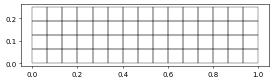

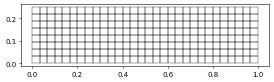

In [3]:
from dune.grid import cartesianDomain, yaspGrid
domain = cartesianDomain([0, 0], [1, 0.25], [15, 4])
yaspView = yaspGrid(domain)

yaspView.plot()
yaspView.hierarchicalGrid.globalRefine()
yaspView.plot()

Let's visualize the grid and then globally refine it once

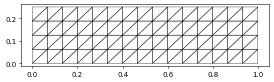

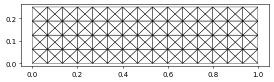

In [4]:

from dune.alugrid import aluConformGrid
aluView = aluConformGrid(domain)
aluView.plot()
aluView.hierarchicalGrid.globalRefine()
aluView.plot()

.. index:: Grid construction; Dictionaries

#### An unstructured grid
can be constructed by providing a dictionary containing vertex coordinate
and element connectivity

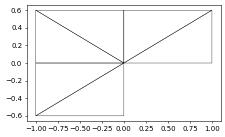

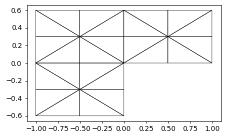

In [5]:
vertices = [(0,0), (1,0), (1,0.6), (0,0.6), (-1,0.6), (-1,0), (-1,-0.6), (0,-0.6)]
triangles = [(2,0,1), (0,2,3), (4,0,3), (0,4,5), (6,0,5), (0,6,7)]
aluView = aluConformGrid({"vertices": vertices, "simplices": triangles})
aluView.plot(figsize=(5,5))
aluView.hierarchicalGrid.globalRefine(2)
aluView.plot(figsize=(5,5))


An unstructured grid can also be constructed from a file.
Currently [gmsh](othergrids_nb.ipynb) and [DGF](othergrids_nb.ipynb) are supported.

.. index:: Adaptation; h-refinement

In addition to global refinement we can also pre process the grid by
marking a subset of elements for local refinement.

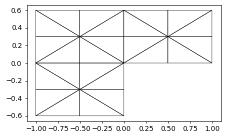

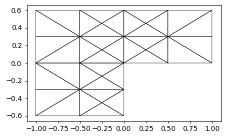

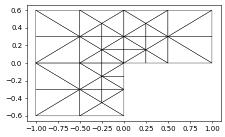

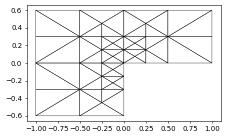

In [6]:
from dune.grid import Marker
aluView.plot(figsize=(5,5))
for i in range(1,4):
    def mark(e):
        x = e.geometry.center
        return Marker.refine if x.two_norm < 0.64**i else Marker.keep
    aluView.hierarchicalGrid.adapt(mark)
    aluView.plot(figsize=(5,5))

from dune.alugrid import aluSimplexGrid
vertices = aluView.coordinates()
triangles = [aluView.indexSet.subIndices(e, 2) for e in aluView.elements]
aluView = aluSimplexGrid({"vertices": vertices, "simplices": triangles})

.. index::
   pair: Overview; Iterators

We next discuss how to retrieve basic information from a constructed grid
and iterate over its entities (i.e., elements, faces, edges, vertices, etc.).

In [7]:
vertices = [(0,0), (1,0), (1,1), (0,1)]
triangles = [(2,0,1), (0,2,3)]
unitSquare = aluSimplexGrid({"vertices": vertices, "simplices": triangles})
print(unitSquare.size(0),"elements and",unitSquare.size(2),"vertices")

for codim in range(0, unitSquare.dimension+1):
    for entity in unitSquare.entities(codim):
        print(", ".join(str(c) for c in entity.geometry.corners))

for edge in unitSquare.edges:
    print(", ".join(str(c) for c in edge.geometry.corners))

2 elements and 4 vertices
(1.000000, 1.000000), (1.000000, 0.000000), (0.000000, 0.000000)
(0.000000, 0.000000), (0.000000, 1.000000), (1.000000, 1.000000)
(0.000000, 0.000000), (1.000000, 0.000000)
(0.000000, 0.000000), (1.000000, 1.000000)
(0.000000, 0.000000), (0.000000, 1.000000)
(1.000000, 0.000000), (1.000000, 1.000000)
(1.000000, 1.000000), (0.000000, 1.000000)
(0.000000, 0.000000)
(1.000000, 0.000000)
(1.000000, 1.000000)
(0.000000, 1.000000)
(0.000000, 0.000000), (1.000000, 0.000000)
(0.000000, 0.000000), (1.000000, 1.000000)
(0.000000, 0.000000), (0.000000, 1.000000)
(1.000000, 0.000000), (1.000000, 1.000000)
(1.000000, 1.000000), (0.000000, 1.000000)


In the above we have used the geometry method on the entity which
provides the geometric mapping between the reference element of the
entity and it's position in physical space. We have used the corners
method to retrieve corners of the entity. Other properties and methods
are available to provide volume or the integration element needed to
compute quadratures of a grid function over the element -
which is discussed in the next section.

# Using grid functions
.. index::
   pair: Functions; Grid Functions

This is a fundamental concept in any grid based discretization package.
These are functions that can be evaluated given an entity in the grid and
a local coordinate within the reference element of that entity.

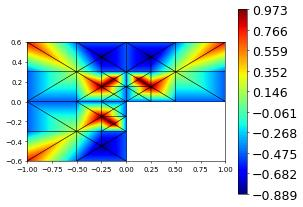

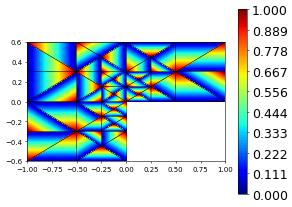

In [8]:
@dune.fem.function.gridFunction(aluView, name="cos", order=3)
def f(x):
    return numpy.cos(2.*numpy.pi/(0.3+abs(x[0]*x[1])))

@dune.fem.function.gridFunction(aluView, name="hat0", order=3)
def hat0(element,hatx):
    return 1-hatx[0]-hatx[1]

hatx = FieldVector([1./3., 1./3.])
maxValue = max(f(e, hatx) for e in f.gridView.elements)

maxValue = max(f(e.geometry.toGlobal(hatx)) for e in f.gridView.elements)

f.plot()
hat0.plot()

.. index::
   pair: Quadratures; Simple Quadrature Rules

We can now use the quadrature rules discuss at the beginning of this
chapter to compute the integral over each element of the grid function.

In [9]:
from dune.geometry import quadratureRules
rules = quadratureRules(5)
integral = 0
for e in aluView.elements:
    geo = e.geometry
    for qp in rules(e.type):
        x,w = qp.position, qp.weight
        integral += f(e,x)*w*geo.integrationElement(x)
print("integral of function 'f':",integral)

integral of function 'f': 0.07942992585030194


There are some approach available to improve the efficiency of the
computation of integrals since this is an important component of many
grid based schemes. Especially, using vectorization can greatly reduce
the complexity of the above loop:

In [10]:
integral = 0
for e in aluView.elements:
    # obtain numpy arrays containing the points and weights and then call
    # required functions using these vectors with requiring a loop
    points, weights = rules(e.type).get()
    ies = e.geometry.integrationElement(points)
    values = f(e,points)
    integral += numpy.sum(values*ies*weights,axis=-1)
print("integral of function 'f':",integral)

integral of function 'f': 0.07942992585030188


Now a vector valued function

In [11]:
# an easy case
dimR = 2
@dune.fem.function.gridFunction(aluView, name="g", order=3)
def g(x):
    return [numpy.cos(2.*numpy.pi/(0.3+abs(x[0]*x[1])))]*dimR
# bit more complex to code
@dune.fem.function.gridFunction(aluView, name="g", order=3)
def g(x):
    if type(x[0]) is float:
        return [numpy.cos(2.*numpy.pi/(0.3+abs(x[0]*x[1]))),1]
    else:
        return [numpy.cos(2.*numpy.pi/(0.3+abs(x[0]*x[1]))),[1]*len(x[0])]
integral = g.dimRange*[0]
for e in aluView.elements:
    # obtain numpy arrays containing the points and weights and then call
    # required functions using these vectors with requiring a loop
    points, weights = rules(e.type).get()
    ies = e.geometry.integrationElement(points)
    values = g(e,points)
    integral += numpy.sum(values*ies*weights,axis=-1)
print("integral of function 'g':",integral)

integral of function 'g': [0.07942993 1.8       ]


.. index::
   triple: Algorithm; C++; User defined code

# Importing user defined C++ code
To achieve close to native efficiency the Python prototype
can be easily reimplemented as a C++ function and the `algorithm` module
used for just in time compilation. This is discussed in a later section
based on [some examples](cpp.rst).

.. index:: Grids; Attaching data

.. index::
   pair: Overview; Dof Mappers

# Attaching Data to the Grid
To attach data to the entities in a grid, each Dune grid has an
`IndexSet` which provides a consecutive, zero starting integer for the
set of entities of a given geometry type, i.e., entities sharing the same
reference element, like all triangles or all cubes. This can be used to attach
data to the these entities stored in random access containers like
`numpy` arrays. To simplify the process further a `mapper` can be used
which is initialized with the data layout, i.e., the number of degrees of
freedom that is supposed to be attached to every entity with a given
geometry type.

In [12]:
mapper = unitSquare.mapper([2, 0, 3])

layout = {dune.geometry.quadrilateral: 4, dune.geometry.triangle: 1}
mapper = unitSquare.mapper(layout)

def interpolate(grid):
    mapper = grid.mapper({dune.geometry.vertex: 1})
    data = numpy.zeros(mapper.size)
    for v in grid.vertices:
        data[mapper.index(v)] = f(v.geometry.center)
    return mapper, data

mapper, data = interpolate(aluView)
@dune.fem.function.gridFunction(aluView, name="p12d", order=1)
def p12dEvaluate(e, x):
    bary = 1-x[0]-x[1], x[0], x[1]
    idx = mapper.subIndices(e, 2)
    return sum(b * data[i] for b, i in zip(bary, idx))

@dune.fem.function.gridFunction(aluView, name="error", order=3)
def error(e, x):
    return abs(p12dEvaluate(e, x)-f(e, x))
hatx = FieldVector([1./3., 1./3.])
print(max(error(e, hatx) for e in aluView.elements))

1.6026566867981322


.. index::
   pair: Grids; Plotting

.. index::
   pair: I/O; Plotting

# Output of Grid and Visualization of Data
We already used `matplotlib` to plot the grid and grid functions. For more
flexible plotting Dune relies on `vtk` and Dune-Python makes it easy to
write suitable files.

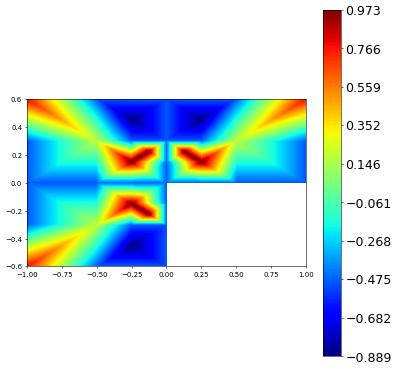

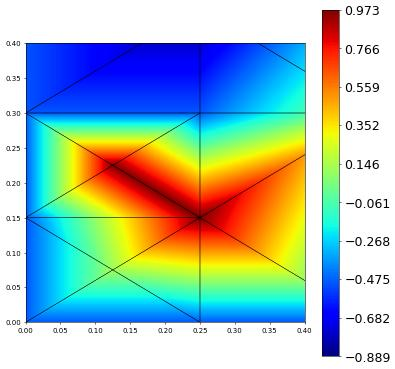

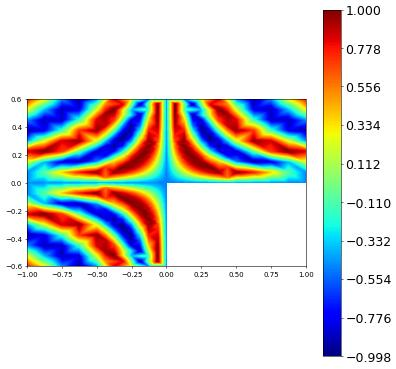

In [13]:
p12dEvaluate.plot(figsize=(9,9), gridLines=None)
p12dEvaluate.plot(figsize=(9,9), gridLines='black',
             xlim=[0,0.4], ylim=[0,0.4])
f.plot(level=2, figsize=(9,9), gridLines=None)

pd = {"exact": f, "discrete": p12dEvaluate, "error": error}
aluView.writeVTK("interpolation", pointdata=pd)

aluView.writeVTK("interpolation_subsampled", subsampling=2, pointdata=pd)

![interpolation](figures/interpolation_discrete.png)
![exact solution](figures/interpolation_exact.png)
![interpolation error](figures/interpolation_error.png)

Mayavi can also be used to plot grid function in Python. This approach
relies on methods to extract `numpy` representations of the grid data
structure and values of a given grid function.

In [14]:
level = 3
triangulation = f.gridView.triangulation(level)
z = f.pointData(level)[:,0]
try:
    from mayavi import mlab
    from mayavi.tools.notebook import display
    mlab.init_notebook("png")
    mlab.figure(bgcolor = (1,1,1))
    s = mlab.triangular_mesh(triangulation.x, triangulation.y, z*0.5,
                             triangulation.triangles)
    display( s )
    # mlab.savefig("mayavi.png", size=(400,300))
    mlab.close(all=True)
except ImportError:
    print("mayavi module not found so not rendering plot - ignored")
    pass

mayavi module not found so not rendering plot - ignored
